## Universal Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy


def PBC(R, L):
    """
    Apply periodic boundary conditions to particle positions
    in a cubic box of side length L.

    Parameters
    ----------
    R : np.array, shape (N, N, 3)
        particle positions
    L : float
        box side length

    Returns
    -------
    np.array, shape (N, N, 3) : particle positions after PBC
    """

    return R - L * np.round(R / L)


def KE(vel, mass):
    """
    Calculate total kinetic energy.

    Parameters
    ----------
    vel : np.array, shape (N, 3)
        particle velocities
    mass : float
        particle mass

    Returns
    -------
    float
        total kinetic energy
    """
    return np.sum(np.linalg.norm(vel) ** 2 / 2 * mass)


def PE(distance_table):
    """
    Calculate total potential energy.

    Parameters
    ----------
    distance_table : np.array, shape (N, N)
        distance table

    Returns
    -------
    float
        total potential energy
    """

    n = distance_table.shape[0]
    # Create an upper triangular mask
    mask = np.triu(np.ones((n, n), dtype=bool), k=1)
    r = distance_table[mask]  # Extract the upper triangular elements of rij
    sixth = 1 / r**6
    pe = np.sum(a=4 * sixth * (sixth - 1))

    return pe


def PEi(i, distance_table, rc):
    """
    Compute shifted Leonord Jones potential energy for particle i

    Args:
        i (int): particle index
        distance_table (np.array): single particle distance table, shape (N, )
        L (float): cubic box side length
        rc (float): potential cutoff radius
    Return:
        pe (float): potential energy for particle i
    """

    sixth_rc = rc**-6
    vshift = 4 * sixth_rc * (sixth_rc - 1)
    rc_mask = distance_table < rc
    i_mask = np.arange(distance_table.shape[0]) != i
    mask = rc_mask & i_mask
    sixth = distance_table[mask] ** -6
    pe = np.sum(4 * sixth * (sixth - 1) - vshift)

    return pe


def distance(R, L):
    """
    Compute distance table and rij vectors

    Parameters
    ----------
    R : np.array, shape (N, 3)
        particle positions
    L : float
        box side length

    Returns
    -------
    np.array, shape (N, N) : distance table
    np.array, shape (N, N, 3) : rij vectors
    """

    rij = R[:, np.newaxis, :] - R
    rij = PBC(rij, L)
    distance_table = np.linalg.norm(rij, axis=2)

    return distance_table, rij


def distancei(i, R, L):
    """
    Compute distance table and rij vectors for a single particle

    Args:
        i (int): particle index
        R (np.array) : particle positions, shape (N, 3)
        L (float): side length of cubic box
    Returns:
        distance_table (np.array): distance table, shape (N, )
        rij (np.array): rij vectors, shape (N, 3)
    """

    rij = R[i] - R
    rij = PBC(rij, L)
    distance_table = np.linalg.norm(rij, axis=1)

    return distance_table, rij


def F(rij, distance_table):
    """
    Compute force on all particles

    Args:
        rij (np.array) : distance vectors, shape (nparticles, nparticles, 3)
        distance_table (np.array): distance table, shape (nparticles, nparticles)
    Returns:
        np.array: force on all particles, shape (nparticles, 3)
    """

    n = rij.shape[0]
    mask = ~np.eye(n, dtype=bool)
    rij = rij[mask].reshape(n, -1, 3)  # Remove self-interaction
    distance_table = distance_table[mask].reshape(n, -1)  # Remove self-interaction
    sixth = (1 / distance_table) ** 6
    factor = (1 / distance_table**2) * sixth * (2 * sixth - 1)
    factor = factor[:, :, np.newaxis]
    force = np.sum(factor * rij, axis=1)

    return 24 * force


def Fi(i, distance_table, rij, rc):
    """
    Calculate the force experienced by particle i

    Args:
        i (int): particle index
        distance_table (np.array): single particle distance table, shape (N, )
        rij (np.array): single particle rij vectors, shape (N, 3)
        rc (float): potential cutoff radius
    Return:
        force (np.array): force on particle i, shape (d,)
    """

    N = distance_table.shape[0]
    i_mask = np.arange(N) != i
    rc_mask = distance_table < rc
    mask = rc_mask & i_mask

    sixth = distance_table[mask] ** -6

    force = 24 * np.dot(distance_table[mask] ** -2 * sixth * (2 * sixth - 1), rij[mask])

    return force


def totalMomentum(vel, mass):
    """
    Calculate total kinetic momentum.

    Args:
        vel (np.array): particle velocities, shape (nparticle, 3)
        mass (float): particle mass
    Returns:
        float: total momentum
    """

    return np.sum(vel * mass, axis=0)


def pairCorrelation(distances, L, dr):
    """
    Calculate the pair correlation function g(r)

    Args:
        distances (np.array): array of distances, shape (nsteps, N, N)
        L (float): box side length
        dr (float): size of bins
    Returns:
        r (np.array): array of bin centers, shape (nbins,)
        g (np.array): pair correlation function, shape (nbins,)
    """
    N = distances.shape[1]
    nsteps = distances.shape[0]
    # Remove self-distance
    mask = ~np.eye(N, dtype=bool)
    mask = np.broadcast_to(mask, (nsteps, N, N))
    distances = distances.copy()[mask].flatten()
    # Calculate histogram
    nbins = int(L / 2 / dr)
    histogram = np.histogram(distances, bins=nbins, range=(0, nbins * dr))
    counts = histogram[0]
    r = (histogram[1] + dr / 2)[:-1]  # centers of the bins
    # Shell volume
    outer_shell_volume = 4 * np.pi / 3 * (r + dr / 2) ** 3
    inner_shell_volume = 4 * np.pi / 3 * (r - dr / 2) ** 3
    shell_volume = outer_shell_volume - inner_shell_volume
    # normalize and average
    V = L**3
    rho = N / V
    normalization = rho * shell_volume  # expected count
    g = counts / normalization
    g /= N  # Average over particles
    g /= nsteps  # Average over time

    return r, g


def legalKvecs(maxn, lbox):
    """
    Calculate k vectors commensurate with a cubic box.

    Consider only k vectors in the all-positive octant of reciprocal space.

    Args:
        maxn : maximum value for nx, ny, nz; maxn+1 is number of k-points along each axis
        lbox : side length of cubic cell

    Returns:
        array of shape (nk, ndim): collection of k vectors
    """
    n = np.arange(maxn + 1)
    n = np.vstack(np.meshgrid(n, n, n)).reshape(3, -1).T
    kvecs = 2 * np.pi / lbox * n
    tmp = np.array(kvecs[:, 0])
    kvecs[:, 0] = kvecs[:, 1]
    kvecs[:, 1] = tmp
    return kvecs


def calcRhok(kvecs, Rs):
    """
    Calculate the fourier transform of particle density.

    Args:
        kvecs (np.array): array of k-vectors, shape (nk, d)
        pos (np.array): particle positions, shape (nsteps, N, d)
    Returns:
        array of shape (nk,): fourier transformed density rho_k
    """
    return np.sum(np.exp(-1j * (Rs @ kvecs.T)), axis=1)


def Sk(maxn, L, Rs):
    """
    Calculate the structure factor S(k).

    Args:
        maxn (int): maximum value for nx, ny, nz; maxn+1 is number of k-points along each axis
        L (float): side length of cubic cell
        Rs (np.array): particle positions, shape (nsteps, N, d)
    Returns:
        unique_kmags (np.array): array of unique k magnitudes, shape (nk,)
        sk (np.array): structure factor s(k), shape (nk, )

    """
    Rs = Rs.copy()

    if Rs.ndim == 2:
        Rs = Rs[np.newaxis, :, :]

    nsteps = Rs.shape[0]
    N = Rs.shape[1]
    kvecs = legalKvecs(maxn, L)
    kmags = np.linalg.norm(kvecs, axis=1)
    unique_kmags = np.unique(kmags)
    Nunique = unique_kmags.shape[0]
    unique_sks = np.zeros((nsteps, Nunique), dtype=np.complex64)
    rhok = calcRhok(kvecs, Rs)
    sk = rhok * rhok.conj() / N

    for i, k in enumerate(unique_kmags):
        mask = kmags == k
        unique_sks[:, i] = np.mean(sk[:, mask], axis=1)

    return unique_kmags, np.mean(unique_sks, axis=0)


def Vacf0(all_vel, t):
    """
    Calculate the vacf using t_0=0.

    Args:
        all_vel (np.array): shape (nstep, natom, ndim), all particle velocities
        from an MD trajectory. For example all_vel[t, i] is the velocity
        vector of particle i at time t.
        t (int): time index at which the velocity auto-correlation is calculated.
    Returns:
        float: the velocity autocorrelation between time 0 and time t
    """
    vacf = 0
    for i in range(all_vel.shape[1]):
        vacf += np.dot(all_vel[0, i], all_vel[t, i])
    return vacf / all_vel.shape[1]


def diffusionConstant(vacf):
    """
    Calculate the diffusion constant from the
    velocity-velocity auto-correlation function (vacf).

    Args:
        vacf (np.array): shape (nt,), vacf sampled at
        nt time steps from t=0 to nt*dt. dt is set to 0.032.
    Returns:
        float: the diffusion constant calculated from the vacf.
    """
    dt = 0.032
    return np.trapz(vacf, dx=dt) / 3


def actime(E):
    """
    Calculate the autocorrelation time for a time series E

    Args:
        E (np.array): array of energies, shape (N,)
    Returns:
        (float, int): (kappa, tcutoff), the autocorrelation time and the cutoff time
    """

    mu = np.mean(E)
    std = np.std(E, ddof=1)
    N = E.shape[0]
    ts = np.arange(0, N, 1)

    a_diffs = np.zeros((N, N))

    for t in ts:
        a_diffs[t][: N - t] = (E[: N - t] - mu) * (E[t:] - mu)

    autocorrelation = np.sum(a_diffs, axis=1) / std**2 / (N - ts)
    tcutoff = (
        np.where(autocorrelation <= 0)[0][0] if (autocorrelation <= 0).any() else 0
    )
    kappa = 1 + 2 * np.sum(autocorrelation[1:tcutoff])

    return autocorrelation, kappa, tcutoff


def stderr(a):
    kappa, tcutoff = actime(a)
    N = a.shape[0]
    std = np.std(a, ddof=1)

    return std / np.sqrt(N / kappa)


def initPositionCubic(N, L):
    """
    Places Ncube^3 atoms in a cubic box

    Args:
        Ncube (int): cube root number of atoms
        L (float): box side length
    Returns:
        np.array: positions, shape (Ncube**3, 3)
    """
    import math

    Ncube = math.ceil(N ** (1 / 3))
    rs = L / Ncube
    roffset = L / 2 - rs / 2
    x = np.linspace(-roffset, roffset, Ncube)
    # Create a grid of positions using numpy broadcasting
    x, y, z = np.meshgrid(x, x, x, indexing="ij")
    # Stack the positions into a single array
    position = np.column_stack((x.ravel(), y.ravel(), z.ravel()))

    return position


def initVelocity(N, T0, mass=1.0, seed=1):
    """
    Initialize velocities from a Maxwell-Boltzmann distribution

    Args:
        N (int): number of particles
        T0 (float): temperature
        mass (float): particle mass
        seed (int): random seed
    Returns:
        np.array: velocities, shape (N, 3)
    """

    dim = 3
    np.random.seed(seed)
    # generate N x dim array of random numbers, and shift to be [-0.5, 0.5)
    velocity = np.random.random((N, dim)) - 0.5
    # get the average along the first axis
    meanV = np.sum(velocity, axis=0) / N
    # subtract off meanV, so there is no net momentum
    velocity -= meanV
    # calculate the total of V^2
    ke = np.sum(velocity * velocity)
    # calculate a scaling factor
    vscale = np.sqrt(dim * N * T0 / (mass * ke))
    # rescale
    velocity *= vscale

    return velocity


def LCG(m, a, c, x0, N):
    """
    Input:
    m, a, c are parameters of the LCG.
    x0: the initial pseduo-random number.
    N : number of random numbers to return

    Output:
    a list or numpy array of length N, containing the next
    N pseduo-random numbers in order (excluding x0).
    """

    output = np.zeros(N + 1)
    output[0] = x0

    for i in range(1, N + 1):
        output[i] = (a * output[i - 1] + c) % m

    return output[1:]


def gaussianRNG(m, a, c, x0, N):
    """
    Input:
    m, a, c, x0 are parameters of the LCG.
    N : number of Gaussian random numbers to return

    Output:
    a list or numpy array of length N, containing the next N
    Gaussian pseduo-random numbers in order (excluding x0).
    """

    uniform = LCG(m, a, c, x0, 2 * N) / m

    output = np.zeros(N)

    for i in range(N):
        output[i] = np.sqrt(-2 * np.log(uniform[2 * i])) * np.sin(
            2 * np.pi * uniform[2 * i + 1]
        )

    return output


def checkRandomNumbers(rand_array, NB):
    """
    Input:
    rand_array: array of size N-by-d, so (rand_array[0][0], rand_array[0][1],
                rand_array[0][2]) is the first 3D point
    NB: number of bins per dimension (for 3D we need NB*NB*NB bins in total)

    Output:
    the chi-squared value of the rand_array,
    using NB**d evenly spaced bins each in [0,1).
    """

    N = rand_array.shape[0]
    d = rand_array.shape[1]
    n = N / NB**d

    counts, edges = np.histogramdd(rand_array, bins=NB, range=[[0, 1]] * d)

    chi2 = np.sum((counts - n) ** 2 / n)

    return chi2


def computeIntegralMidpoint(func, L, N):
    """
    Input:
    func: function with a single input f(x)
    L: sets the bounds of the integral by [-L, L]
    N: number of rectangles

    Output:
    the integral using rectangle rule
    """

    dx = 2 * L / N
    x = -L + dx / 2
    s = 0

    while x <= L:
        s += func(x) * dx

        x += dx

    return s


def computeIntegralMC(func, alpha, N):
    """
    Input:
    func: a well defined function that decays fast when |x| goes to infinity
    alpha: variance of the normal distribution to be sampled
    N: length of Gaussian random numbers

    Output:
    a two-element list or numpy array, with the first element being the estimate of
    the integral, and the second being the the estimate of the variance
    """

    m = 2**32
    a = 69069
    c = 1
    x0 = 0

    # Multiply Gaussian random numbers by np.sqrt(alpha)
    # to make their variance equal to alpha
    gaussian_arrays = np.sqrt(alpha) * np.array(gaussianRNG(m, a, c, x0, N))

    # PDF of the normal distribution
    def p(x, alpha):
        return np.exp(-x * x / (2.0 * alpha)) / np.sqrt(2.0 * np.pi * alpha)

    fx = func(gaussian_arrays)
    px = p(gaussian_arrays, alpha)

    gx = fx / px
    mean = np.mean(gx)
    variance = np.var(gx)
    return mean, variance

## MD Functions

In [4]:
def verletNextR(r_t, v_t, a_t, h):
    """
    Return new positions after one Verlet step

    Args:
        r_t (np.array): positions at time t, shape (nparticles, ndim)
        v_t (np.array): velocities at time t, shape (nparticles, ndim)
        a_t (np.array): accelerations at time t, shape (nparticles, ndim)
        h (float): timestep
    Returns:
        np.array: positions at time t+h, shape (nparticles, ndim)
    """

    # Note that these are vector quantities.
    # Numpy loops over the coordinates for us.
    r_t_plus_h = r_t + v_t * h + 0.5 * a_t * h * h

    return r_t_plus_h


def verletNextV(v_t, a_t, a_t_plus_h, h):
    """
    Return new velocities after one Verlet step

    Args:
        v_t (np.array): velocities at time t, shape (nparticles, ndim)
        a_t (np.array): accelerations at time t, shape (nparticles, ndim)
        a_t_plus_h (np.array): accelerations at time t+h, shape (nparticles, ndim)
        h (float): timestep

    Returns:
        np.array: velocities at time t+h, shape (nparticles, ndim)
    """

    # Note that these are vector quantities.
    # Numpy loops over the coordinates for us.
    v_t_plus_h = v_t + 0.5 * (a_t + a_t_plus_h) * h

    return v_t_plus_h


def simulateMD(Ncube, T0, L, M, steps, h, thermostat=False, p=0.01, T_bath=None):
    """
    Initialize and run a simulation in a Ncube**3 box, for steps

    Args:
        Ncube (int): cube root number of atoms
        T0 (float): temperature
        L (float): box side length
        M (float): particle mass
        steps (int): number of steps to run
        h (float): timestep
    Returns:
        np.array: total energy, shape (steps,)
    """

    np.random.seed(1)

    # Initialize inputs
    N = Ncube**3
    R = initPositionCubic(Ncube, L)
    V = initVelocity(N, T0, M)
    A = np.zeros((N, 3))

    # Initialize outputs
    E = np.zeros(steps)
    P = np.zeros((steps, 3))
    T = np.zeros(steps)
    Vs = np.zeros((steps, N, 3))
    Rs = np.zeros((steps, N, 3))
    distances = np.zeros((steps, N, N))

    # Calculate initial Forces and accelerations (N x 3 array)
    distance_table, rij = distance(R, L)
    Force = F(rij, distance_table)
    A = Force / M

    for t in range(0, steps):
        # Calculate energy, temperature, and momentum
        E[t] = KE(V, M)
        T[t] = 2 * E[t] / (3 * N)
        E[t] += PE(distance_table)
        P[t] = totalMomentum(V, M)

        # Save velocities, positions, and distances
        Vs[t] = V
        Rs[t] = R
        distances[t] = distance_table

        # Calculate next positions and apply PBC
        nR = verletNextR(R, V, A, h)
        nR = PBC(nR, L)
        distance_table, rij = distance(nR, L)

        # Calculate next forces, accelerations, and velocities
        nF = F(rij, distance_table)
        nA = nF / M
        nV = verletNextV(V, A, nA, h)

        if thermostat:
            collission_mask = np.random.rand(N) <= p
            if T_bath is None:
                nV[collission_mask] = np.random.normal(
                    0, np.sqrt(T0 / M), size=(np.sum(collission_mask), 3)
                )
            else:
                nV[collission_mask] = np.random.normal(
                    0, np.sqrt(T_bath / M), size=(np.sum(collission_mask), 3)
                )

        # update positions, velocities, accelerations and forces
        R, V, A, Force = nR, nV, nA, nF

    return E, P, T, Vs, Rs, distances

## MC MD Functions (Smart and Metropolis)

In [2]:
def generateEta(N, d, sigma):
    """
    Generate Gaussian random numbers for Metropolis Monte Carlo moves

    Args:
        N (int): number of particles
        d (int): dimension of space
        sigma (float): width of Gaussian random numbers
    Returns:
        np.array: array of shape (N, d) of Gaussian random numbers
    """

    return np.random.normal(loc=0, scale=sigma, size=(N, d))


def generateAcceptCheck(N):
    """
    Generate uniform random numbers for Monte Carlo acceptance checks

    Args:
        N (int): number of particles
    Returns:
        np.array: array of shape (N,) of uniform random numbers
    """
    return np.random.uniform(low=0, high=1, size=N)


def generateEtaSmart(N, d, sigma, xadjust):
    """
    Generate Gaussian random numbers for Smart Monte Carlo moves

    Args:
        N (int): number of particles
        d (int): dimension of space
        sigma (float): width of Gaussian random numbers
        xadjust (float): adjustment to Gaussian random numbers
    Returns:
        np.array: array of shape (N, d) of Gaussian random numbers

    """
    return np.random.normal(xadjust, sigma, (N, d))


def mcSweepMetropolis(R, L, rc, beta, eta, accept_check):
    """Perform one Monte Carlo sweep

    Args:
        R (np.array): particle positions, shape (N, d)
        L (float): cubic box side length
        rc (float): potential cutoff radius
        beta (float): inverse temperature
        eta (np.array): shape (N, d), array of Gaussian random numbers, one for each single-particle move
        accept_check (np.array): shape (natom), array of uniform random numbers, one for each single particle move
    Return:
        (int, float): (naccept, dR), the number of accepted single-particle moves, and the change in energy
    """
    N, d = R.shape
    naccept = 0
    dE = 0
    R = R.copy()

    for i in range(N):
        nR = R.copy()
        nR[i] = PBC(nR[i] + eta[i], L)
        distance_table, rij = distancei(i, R, L)
        PE_old = PEi(i, distance_table, rc)
        distance_new, rij_new = distancei(i, nR, L)
        PE_new = PEi(i, distance_new, rc)
        dEi = PE_new - PE_old
        p = -beta * dEi
        if p > np.log(accept_check[i]):
            R[i] = nR[i]
            naccept += 1
            dE += dEi

    return naccept, dE, R


def mcSweepSmart(R, L, rc, beta, eta, accept_check, sig):
    """Perform one Monte Carlo sweep using smart Monte Carlo moves

    Args:
        R (np.array): particle positions, shape (N, d)
        L (float): cubic box side length
        rc (float): potential cutoff radius
        beta (float): inverse temperature
        eta (np.array): shape (natom, ndim), array of Gaussian random
        numbers, one for each single-particle move
        accept_check (np.array): shape (natom), array of uniform random numbers, one for each single-particle move
        sig (float): width of Gaussian random numbers (eta)
    Return:
        (int, float): (naccept, dE), the number of accepted single-particle moves, and the change in energy
    """
    tau = 0.5 * sig**2

    N, d = R.shape
    naccept = 0
    dE = 0
    R = R.copy()

    for i in range(N):
        distance_table, rij = distancei(i, R, L)
        F_old = Fi(i, distance_table, rij, rc)
        PE_old = PEi(i, distance_table, rc)
        dr = eta[i] + tau * beta * F_old

        nR = R.copy()
        nR[i] = PBC(nR[i] + dr, L)
        distance_new, rij_new = distancei(i, nR, L)
        F_new = Fi(i, distance_new, rij_new, rc)
        PE_new = PEi(i, distance_new, rc)

        dEi = PE_new - PE_old
        T_forward = -np.linalg.norm(dr - tau * beta * F_old) ** 2 / (4 * tau)
        T_back = -np.linalg.norm(-dr - tau * beta * F_new) ** 2 / (4 * tau)
        p = T_back - T_forward
        p += -beta * dEi

        if p > np.log(accept_check[i]):
            R[i] = nR[i]
            naccept += 1
            dE += dEi

    return naccept, dE, R


def simulateMcMetropolis(N, L, T, rc, sigma, steps):
    beta = 1 / T
    R = initPositionCubic(N, L)
    Rs = np.zeros((steps, N, 3))
    Es = np.zeros(steps)
    distances = np.zeros((steps, N, N))
    acceptance_ratios = np.zeros(steps)

    for t in range(steps):
        eta = generateEta(N, 3, sigma)
        accept_check = generateAcceptCheck(N)
        naccept, dE, R = mcSweepMetropolis(R, L, rc, beta, eta, accept_check)

        Rs[t] = R

        distance_table, rij = distance(R, L)
        E = PE(distance_table)
        Es[t] = E
        distances[t] = distance_table
        acceptance_ratios[t] = naccept / N

    return Rs, Es, distances, acceptance_ratios


def simulateMcSmart(N, L, T, M, rc, sigma, steps, dt):
    beta = 1 / T
    R = initPositionCubic(N, L)
    Rs = np.zeros((steps, N, 3))
    Es = np.zeros(steps)
    distances = np.zeros((steps, N, N))
    acceptance_ratios = np.zeros(steps)

    distance0, rij0 = distance(R, L)
    Force = F(rij0, distance0)

    for t in range(steps):
        xadjust = Force / (2 * M) * dt**2

        eta = generateEtaSmart(N, 3, sigma, xadjust)
        accept_check = generateAcceptCheck(N)
        naccept, dE, R = mcSweepSmart(R, L, rc, beta, eta, accept_check, sigma)

        Rs[t] = R

        distance_table, rij = distance(R, L)
        Force = F(rij, distance_table)
        E = PE(distance_table)
        Es[t] = E
        distances[t] = distance_table
        acceptance_ratios[t] = naccept / N

    return Rs, Es, distances, acceptance_ratios

## Ising MD Functions

In [5]:
def totalMagnetization(lattice):
    """Total magnetization of lattice.

    Parameters
    ----------
    lattice : np.array, shape (nx, nx)
        2D lattice of +1 and -1

    Returns
    -------
    int
        total magnetization
    """
    mtot = 0
    if lattice.ndim == 2:
        mtot = np.sum(lattice.flatten())

    elif lattice.ndim == 3:
        mtot = np.sum(lattice, axis=(1, 2))

    return mtot


def varMagnetization(lattice):
    """Variance of magnetization of lattice.

    Parameters
    ----------
    lattice : np.array, shape (nx, ny)
        2D lattice of +1 and -1

    Returns
    -------
    float
        variance of magnetization
    """
    varMag = np.var(lattice.flatten(), ddof=1)
    return varMag


def neighborList(i, j, N):
    """Find all neighbors of site (i, j).

    Parameters
    ----------
    i : int
        site index along x
    j : int
        site index along y
    N : int
        number of sites along each dimension

    Returns
    -------
    np.array
        array of 2-tuples, [(i_left, j_left), (i_above, j_above),
        (i_right, j_right), (i_below, j_below)]
    """

    left = (i - 1, j)
    above = (i, j + 1)
    right = (i + 1, j)
    below = (i, j - 1)

    # fix these indices
    if i == N - 1:
        right = (0, j)

    elif i == 0:
        left = (N - 1, j)

    if j == N - 1:
        above = (i, 0)

    elif j == 0:
        below = (i, N - 1)

    return np.array([left, above, right, below])


def energySite(i, j, lattice):
    """Calculate energy associated with site (i, j)

    The sum of energy_site over all sites should be 2* total energy.

    Parameters
    ----------
    i : int
        site index along x
    j : int
        site index along y
    lattice : np.array, shape (nx, ny)
        2D lattice of +1 and -1

    Returns
    -------
    float
        energy of site (i, j)
    """

    N = lattice.shape[0]
    neighbors = neighborList(i, j, N)
    x_indices = neighbors[:, 0]
    y_indices = neighbors[:, 1]
    energy = -lattice[i, j] * np.sum(lattice[x_indices, y_indices].flatten())
    return energy


def spinFlipRandom(lattice, i, j, beta):
    """Calculate spin flip probability and change to total magnetization.

    Parameters
    ----------
    lattice : np.array, shape (nx, ny)
        2D lattice of +1 and -1
    i : int
        site index along x
    j : int
        site index along y
    beta : float
        inverse temperature

    Returns
    -------
    float
        acceptance ratio
    int
        change to total magnetization due to the spin flip
    """

    dE = -2 * energySite(i, j, lattice)
    A = np.exp(-beta * dE)
    dM = -2 * lattice[i, j]
    return A, dM


def sampleSpinHeatbath(lat, i, j, betaj, rcheck):
    """sample spin for site (i, j) using heat-bath algorithm

    Parameters
    ----------
    lat : np.array, shape (nx, ny)
        2D lattice of +1 and -1
    i : int
        site index along x
    j : int
        site index along y
    betaj : float
        inverse temperature in reduced units
    rcheck : float
        uniform random number for proposed move

    Returns
    -------
    int
        sampled spin
    int
        change to total magnetization
    """

    lattice = copy.deepcopy(lat)
    s0 = lattice[i, j]
    lattice[i, j] = 1
    Pup = np.exp(-betaj * energySite(i, j, lattice))
    lattice[i, j] = -1
    Pdown = np.exp(-betaj * energySite(i, j, lattice))
    T = Pup / (Pup + Pdown)
    if rcheck < T:
        s = 1
    else:
        s = -1
    dmtot = -(s0 - s)
    return s, dmtot


def initLattice(N):
    """Initialize lattice.

    Parameters
    ----------
    N : int
        number of sites along each dimension

    Returns
    -------
    np.array
        2D lattice of +1
    """
    # lattice = np.random.choice([-1, 1], size=(N, N))
    lattice = np.ones((N, N))
    return lattice


def simulateMetropolis(lattice, beta, nsweeps):
    """Simulate Ising model using Metropolis algorithm.

    Parameters
    ----------
    lattice : np.array, shape (nx, ny)
        2D lattice of +1 and -1
    beta : float
        inverse temperature
    nsweeps : int
        number of sweeps

    Returns
    -------
    np.array
        array of magnetizations
    """
    lattice = copy.deepcopy(lattice)
    N = lattice.shape[0]
    Lattices = np.zeros((nsweeps, N, N))
    for sweep in range(nsweeps):
        for i in range(N):
            for j in range(N):
                A, dM = spinFlipRandom(lattice, i, j, beta)
                rcheck = np.random.rand()
                if rcheck < A:
                    lattice[i, j] *= -1

        Lattices[sweep] = lattice

    return Lattices


def simulateHeatbath(lattice, beta, nsweeps):
    """Simulate Ising model using heat-bath algorithm.

    Parameters
    ----------
    lattice : np.array, shape (nx, ny)
        2D lattice of +1 and -1
    beta : float
        inverse temperature
    nsweeps : int
        number of sweeps

    Returns
    -------
    np.array
        array of magnetizations
    """
    lattice = copy.deepcopy(lattice)
    N = lattice.shape[0]
    Lattices = np.zeros((nsweeps, N, N))
    for sweep in range(nsweeps):
        for i in range(N):
            for j in range(N):
                rcheck = np.random.rand()
                s, dmtot = sampleSpinHeatbath(lattice, i, j, beta, rcheck)
                lattice[i, j] = s

        Lattices[sweep] = lattice

    return Lattices


def cluster(beta, lattice, N):
    """
    Cluster algorithm for Ising model

    Parameters
    ----------
    beta : float
        inverse temperature
    lattice : np.array, shape (nx, ny)
        2D lattice of +1 and -1
    N : int
        number of sites along each dimension

    Returns
    -------
    np.array
        array of sites in cluster
    """

    lattice = copy.deepcopy(lattice)
    pos = np.random.randint(0, N, 2)
    s = lattice[pos[0], pos[1]]
    allpos = np.where(lattice == s)
    allpos = np.vstack([allpos[0], allpos[1]]).T
    cluster = []
    passed = []
    cluster.append(pos)
    neighbors = []
    neighbors.extend(neighborList(pos[0], pos[1], N))

    while len(neighbors) > 0:
        i = neighbors[0]

        if (np.isin(i, allpos).all()) and (np.isin(i, passed).all()):
            if (1 - np.exp(-2 * beta)) > np.random.random():
                cluster.append(i)
                neighbors.extend(neighborList(i[0], i[1], N))

            passed.append(i)
        del neighbors[0]
    cluster = np.vstack(cluster)
    return cluster


def simulateCluster(lattice, beta, nsweeps):
    """Simulate Ising model using cluster algorithm.

    Parameters
    ----------
    lattice : np.array, shape (nx, ny)
        2D lattice of +1 and -1
    beta : float
        inverse temperature
    nsweeps : int
        number of sweeps

    Returns
    -------
    np.array
        array of magnetizations
    """

    lattice = copy.deepcopy(lattice)
    N = lattice.shape[0]
    Latices = np.zeros((nsweeps, N, N))

    for sweep in range(nsweeps):
        c = cluster(beta, lattice, N)
        lattice[c] *= -1

        Latices[sweep] = lattice

    return Latices

## Project

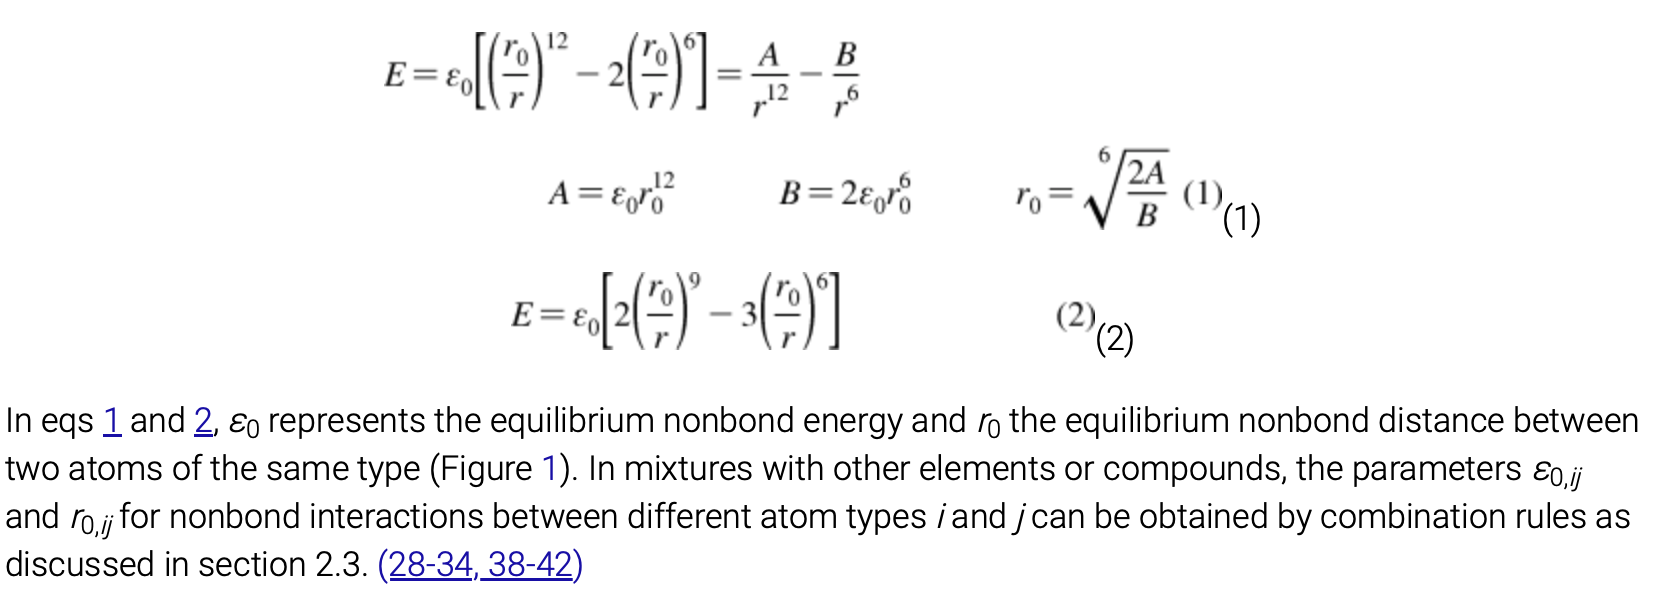

In [6]:
# Cu LJ parameters
eps_cu = 4.72  # kcal/mol
r0_cu = 2.616  # Angstrom (also sigma)
A_cu = 484800  # kcal/mol/Angstrom^12
B_cu = 3026  # kcal/mol/Angstrom^6
a_cu = 3.6147 # Angstrom
E_bind_cu = -87.69 # kcal/mol (room temp)
rc_cu = 1.2  # nm
rc_cu *= 10  # Angstrom
n_cu = 8.96 # g/cm^3 / 63.546 g/mol * 6.022e23  # number density

# Al LJ parameters
eps_al = 4.02 # kcal/mol
r0_al = 2.925 # Angstrom (also sigma)
A_al = 1577000 # kcal/mol/Angstrom^12
B_al = 5035 # kcal/mol/Angstrom^6
a_al = 4.0495 # Angstrom

In [10]:
eps = 0.52031 # eV
eps = eps * 23.0605 # kcal/mol
print(eps)

11.998608755000001


In [8]:
def initPositionFCC(Ncell, a):
    """
    Places atoms in a fcc box

    Args:
        Ncell (int): supercell dimension in cubic-wise
        a (float): lattice constant
    Returns:
        (float, float, np.array): (N, L, position)
    """
    import math

    L = Ncell * a

    rs = L / Ncell
    roffset = L / 2
    x = np.linspace(-L / 2, -L / 2 + a * (Ncell - 1), Ncell)
    x, y, z = np.meshgrid(x, x, x, indexing="ij")
    # Stack the edge positions
    position = np.column_stack((x.ravel(), y.ravel(), z.ravel()))

    # Stack the 3 face-positions
    xx = np.column_stack(
        (position[:, 0] + a / 2, position[:, 1] + a / 2, position[:, 2])
    )
    xx = np.delete(xx, np.where((xx > roffset))[0], axis=0)
    yy = np.column_stack(
        (position[:, 0] + a / 2, position[:, 1], position[:, 2] + a / 2)
    )
    yy = np.delete(yy, np.where((yy > roffset))[0], axis=0)
    zz = np.column_stack(
        (position[:, 0], position[:, 1] + a / 2, position[:, 2] + a / 2)
    )
    zz = np.delete(zz, np.where((zz > roffset))[0], axis=0)

    position_new = np.row_stack((position, xx, yy, zz))
    N = position_new.shape[0]

    return N, L, position_new


def LJ(distance_table, rc, A, B):
    sixth_rc = rc**-6
    vshift = A * sixth_rc**2 - B * sixth_rc

    n = distance_table.shape[0]
    i_mask = np.triu(np.ones((n, n), dtype=bool), k=1)
    rc_mask = distance_table < rc
    mask = i_mask & rc_mask
    r = distance_table[mask]
    sixth = r**-6
    v = A * sixth**2 - B * sixth

    return np.sum(v - vshift)


def LJForce(rij, distance_table, rc, A, B):
    n = rij.shape[0]
    i_mask = ~np.eye(n, dtype=bool)
    rij = rij[i_mask].reshape(n, -1, 3)  # Remove self-interaction
    distance_table = distance_table[i_mask].reshape(n, -1)  # Remove self-interaction
    rc_mask = distance_table >= rc
    distance_table[rc_mask] = np.inf
    force = 12 * A * distance_table**-13 - 6 * B * distance_table**-7
    force = force[:, :, np.newaxis]
    force = np.sum(force * rij, axis=1)

    return force

In [9]:
def simulateMD(N, T0, L, M, steps, h, rc, thermostat=False, p=0.01, T_bath=None):
    """
    MD simulation of N particles in a cubic box of side length L

    Parameters
    ----------
    N : int
        number of particles
    T0 : float
        initial temperature
    L : float
        box side length
    M : float
        particle mass
    steps : int
        number of steps to run
    h : float
        timestep
    rc : float
        cutoff radius
    thermostat : bool, optional
        whether to use Andersen thermostat, by default False
    p : float, optional
        probability of collission, by default 0.01
    T_bath : float, optional
        temperature of bath, by default None

    Returns
    -------
    np.array
        total energy, shape (steps,)
    np.array
        total momentum, shape (steps, 3)
    np.array
        temperature, shape (steps,)
    np.array
        velocities, shape (steps, N, 3)
    np.array
        positions, shape (steps, N, 3)
    np.array
        distances, shape (steps, N, N)
    """

    np.random.seed(1)

    # Initialize inputs
    N = N
    R = initPositionCubic(N, L)
    V = initVelocity(N, T0, M)
    A = np.zeros((N, 3))

    # Initialize outputs
    E = np.zeros(steps)
    P = np.zeros((steps, 3))
    T = np.zeros(steps)
    Vs = np.zeros((steps, N, 3))
    Rs = np.zeros((steps, N, 3))
    distances = np.zeros((steps, N, N))

    # Calculate initial Forces and accelerations (N x 3 array)
    distance_table, rij = distance(R, L)
    Force = LJForce(rij, distance_table, rc)
    A = Force / M

    for t in range(0, steps):
        # Calculate energy, temperature, and momentum
        E[t] = KE(V, M)
        T[t] = 2 * E[t] / (3 * N)
        E[t] += LJ(distance_table, rc)
        P[t] = totalMomentum(V, M)

        # Save velocities, positions, and distances
        Vs[t] = V
        Rs[t] = R
        distances[t] = distance_table

        # Calculate next positions and apply PBC
        nR = verletNextR(R, V, A, h)
        nR = PBC(nR, L)
        distance_table, rij = distance(nR, L)

        # Calculate next forces, accelerations, and velocities
        nF = LJForce(rij, distance_table, rc)
        nA = nF / M
        nV = verletNextV(V, A, nA, h)

        if thermostat:
            collission_mask = np.random.rand(N) <= p
            if T_bath is None:
                nV[collission_mask] = np.random.normal(
                    0, np.sqrt(T0 / M), size=(np.sum(collission_mask), 3)
                )
            else:
                nV[collission_mask] = np.random.normal(
                    0, np.sqrt(T_bath / M), size=(np.sum(collission_mask), 3)
                )

        # update positions, velocities, accelerations and forces
        R, V, A, Force = nR, nV, nA, nF

    return E, P, T, Vs, Rs, distances

In [11]:
# Cu LJ parameters
eps_cu = 4.72  # kcal/mol
r0_cu = 2.616  # Angstrom (also sigma)
A_cu = 484800  # kcal/mol X Angstrom^12
B_cu = 3026  # kcal/mol X Angstrom^6
a_cu = 3.6147  # Angstrom
E_bind_cu = -87.69  # kcal/mol (room temp)
rc_cu = 1.2  # nm
rc_cu *= 10  # Angstrom
n_cu = 8.96  # g/cm^3 / 63.546 g/mol * 6.022e23  # number density

# Al LJ parameters
eps_al = 4.02  # kcal/mol
r0_al = 2.925  # Angstrom (also sigma)
A_al = 1577000  # kcal/mol/Angstrom^12
B_al = 5035  # kcal/mol/Angstrom^6
a_al = 4.0478  # Angstrom

In [20]:
a_cu * 5

18.0735

In [16]:
(r0_cu)**6 * eps_cu * 2

3025.5088818667286

In [19]:
(B_cu + B_al)/2

4030.5

In [18]:
B_tot = np.sqrt(B_cu * B_al)
print(B_tot)

3903.320381418876


In [17]:
r0_tot = np.sqrt(r0_cu * r0_al)
eps_tot = np.sqrt(eps_cu * eps_al)
B_tot = (r0_tot) ** 6 * eps_tot * 2
print(B_tot)

3903.0566225190973


In [10]:
N = int(5**3)

targetDensity = 0.05234  # particles per Angstrom^3
L = (N / targetDensity) ** (1 / 3)

T0 = 0.6
M = 63.546  # g/mol
steps = 10000
h = 0.001
rc = L / 2

E, P, T, Vs, Rs, distances = simulateMD(
    N, T0, L, M, steps, h, rc, thermostat=True, p=0.02, T_bath=T0
)

10000


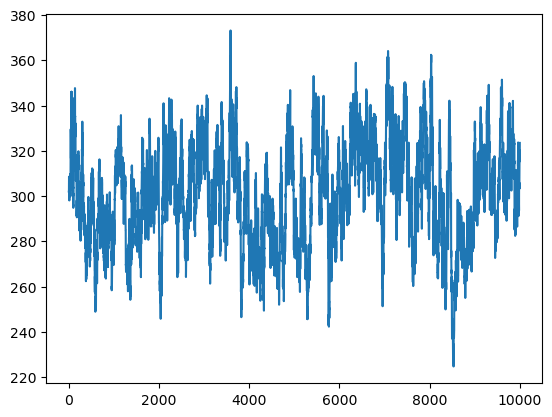

In [11]:
kb = 0.0019872041  # kcal/mol/K
naturalT = T / kb
print(len(naturalT))
plt.plot(naturalT)

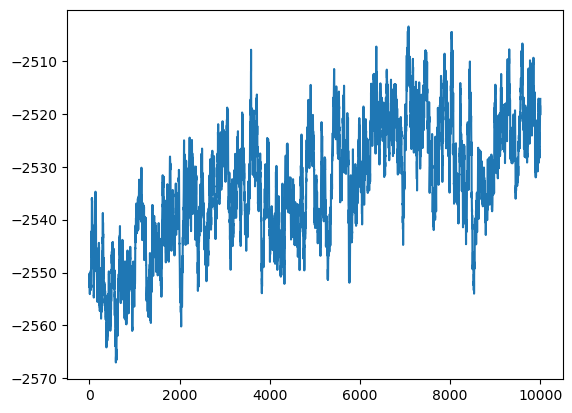

In [12]:
plt.plot(E)

In [13]:
# animate the 3D positions

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from IPython.core.display import HTML

fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection="3d")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("T")
ax.set_title("Positions")
ax.set_zlim(-L / 2, L / 2)
ax.set_xlim(-L / 2, L / 2)
ax.set_ylim(-L / 2, L / 2)
# surf = ax.scatter(Rs[0, :, 0], Rs[0, :, 1], Rs[0, :, 2], s=10)
# plt.show()
plt.close()


def animate(i):
    ax.clear()
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.set_title(f"Position at t = {i:.2f}")
    ax.set_zlim(-L / 2, L / 2)
    ax.set_xlim(-L / 2, L / 2)
    ax.set_ylim(-L / 2, L / 2)
    surf = ax.scatter(Rs[i, :, 0], Rs[i, :, 1], Rs[i, :, 2], s=10)
    return surf


frames = np.arange(0, steps, 100)
anim = animation.FuncAnimation(fig, animate, frames=frames, interval=100)
HTML(anim.to_html5_video())